# 自动编码器
自动编码器最开始是作为一种数据压缩方法，同时还可以在卷积网络中进行逐层预训练，但是随后更多结构复杂的网络，比如 resnet 的出现使得我们能够训练任意深度的网络，自动编码器就不再使用在这个方面，下面我们讲一讲自动编码器的一个新的应用，这是随着生成对抗模型而出现的，就是使用自动编码器生成数据。

自动编码器的一般结构如下

![](https://ws1.sinaimg.cn/large/006tNc79ly1fmzr05igw3j30ni06j3z4.jpg)

由上面的图片，我们能够看到，第一部分是编码器(encoder)，第二部分是解码器(decoder)，编码器和解码器都可以是任意的模型，通常我们可以使用神经网络作为我们的编码器和解码器，输入的数据经过神经网络降维到一个编码，然后又通过另外一个神经网络解码得到一个与原始数据一模一样的生成数据，通过比较原始数据和生成数据，希望他们尽可能接近，所以最小化他们之间的差异来训练网络中编码器和解码器的参数。

当训练完成之后，我们如何生成数据呢？非常简单，我们只需要拿出解码器的部分，然后随机传入 code，就可以通过解码器生成各种各样的数据

![](https://ws3.sinaimg.cn/large/006tNc79ly1fmzrx3d3ygj30nu06ijs2.jpg)

下面我们使用 mnist 数据集来说明一个如何构建一个简单的自动编码器

In [1]:
import os

import torch
from torch.autograd import Variable
from torch import nn
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision import transforms as tfs
from torchvision.utils import save_image

进行数据预处理和迭代器的构建

In [2]:
im_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # 标准化
])

train_set = MNIST('./mnist', transform=im_tfs)
train_data = DataLoader(train_set, batch_size=128, shuffle=True)

In [3]:
# 定义网络
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 3) # 输出的 code 是 3 维，便于可视化
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode

这里定义的编码器和解码器都是 4 层神经网络作为模型，中间使用 relu 激活函数，最后输出的 code 是三维，注意解码器最后我们使用 tanh 作为激活函数，因为输入图片标准化在 -1 ~ 1 之间，所以输出也要在 -1 ~ 1 这个范围内，最后我们可以验证一下

In [4]:
net = autoencoder()
x = Variable(torch.randn(1, 28*28)) # batch size 是 1
code, _ = net(x)
print(code.shape)

torch.Size([1, 3])


可以看到最后得到的 code 就是三维的

In [5]:
criterion = nn.MSELoss(size_average=False)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

def to_img(x):
    '''
    定义一个函数将最后的结果转换回图片
    '''
    x = 0.5 * (x + 1.)
    x = x.clamp(0, 1)
    x = x.view(x.shape[0], 1, 28, 28)
    return x

In [6]:
# 开始训练自动编码器
for e in range(100):
    for im, _ in train_data:
        im = im.view(im.shape[0], -1)
        im = Variable(im)
        # 前向传播
        _, output = net(im)
        loss = criterion(output, im) / im.shape[0] # 平均
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (e+1) % 20 == 0: # 每 20 次，将生成的图片保存一下
        print('epoch: {}, Loss: {:.4f}'.format(e + 1, loss.data[0]))
        pic = to_img(output.cpu().data)
        if not os.path.exists('./simple_autoencoder'):
            os.mkdir('./simple_autoencoder')
        save_image(pic, './simple_autoencoder/image_{}.png'.format(e + 1))

epoch: 20, Loss: 109.0523
epoch: 40, Loss: 95.4651
epoch: 60, Loss: 89.8394
epoch: 80, Loss: 107.5620
epoch: 100, Loss: 92.2142


训练完成之后我们可以看看生成的图片效果

![](https://ws2.sinaimg.cn/large/006tNc79ly1fmzw2c26qtj306q0a2abh.jpg)

可以看出，图片还是具有较好的清晰度

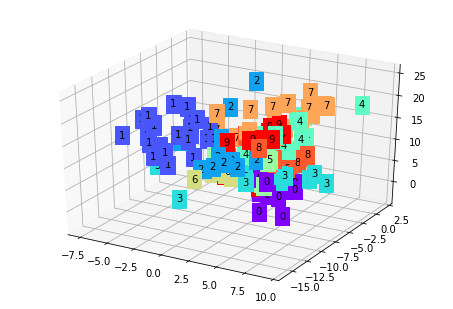

In [7]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# 可视化结果
view_data = Variable((train_set.train_data[:200].type(torch.FloatTensor).view(-1, 28*28) / 255. - 0.5) / 0.5)
encode, _ = net(view_data)    # 提取压缩的特征值
fig = plt.figure(2)
ax = Axes3D(fig)    # 3D 图
# x, y, z 的数据值
X = encode.data[:, 0].numpy()
Y = encode.data[:, 1].numpy()
Z = encode.data[:, 2].numpy()
values = train_set.train_labels[:200].numpy()  # 标签值
for x, y, z, s in zip(X, Y, Z, values):
    c = cm.rainbow(int(255*s/9))    # 上色
    ax.text(x, y, z, s, backgroundcolor=c)  # 标位子
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()

可以看到，不同种类的图片进入自动编码器之后会被编码得不同，而相同类型的图片经过自动编码之后的编码在几何示意图上距离较近，在训练好自动编码器之后，我们可以给一个随机的 code，通过 decoder 生成图片

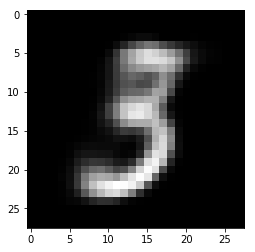

In [24]:
code = Variable(torch.FloatTensor([[1.19, -3.36, 2.06]])) # 给一个 code 是 (1.19, -3.36, 2.06)
decode = net.decoder(code)
decode_img = to_img(decode).squeeze()
decode_img = decode_img.data.numpy() * 255
plt.imshow(decode_img.astype('uint8'), cmap='gray') # 生成图片 3

这里我们仅仅使用多层神经网络定义了一个自动编码器，当然你会想到，为什么不使用效果更好的卷积神经网络呢？我们当然可以使用卷积神经网络来定义，下面我们就重新定义一个卷积神经网络来进行 autoencoder

In [25]:
class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # (b, 16, 10, 10)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # (b, 16, 5, 5)
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # (b, 8, 3, 3)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # (b, 8, 2, 2)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # (b, 16, 5, 5)
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # (b, 8, 15, 15)
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # (b, 1, 28, 28)
            nn.Tanh()
        )

    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode

In [26]:
conv_net = conv_autoencoder()
if torch.cuda.is_available():
    conv_net = conv_net.cuda()
optimizer = torch.optim.Adam(conv_net.parameters(), lr=1e-3, weight_decay=1e-5)

对于卷积网络中，我们可以对输入进行上采样，那么对于卷积神经网络，我们可以使用转置卷积进行这个操作，这里我们先不展开讨论转置卷积，如果想先了解转置卷积，可以看看[语义分割](https://github.com/SherlockLiao/code-of-learn-deep-learning-with-pytorch/blob/master/chapter9_Computer-Vision/segmentation/fcn.ipynb)的部分，里面有转置卷积的介绍

在 pytorch 中使用转置卷积就是上面的操作，`torch.nn.ConvTranspose2d()` 就可以了

In [28]:
# 开始训练自动编码器
for e in range(40):
    for im, _ in train_data:
        if torch.cuda.is_available():
            im = im.cuda()
        im = Variable(im)
        # 前向传播
        _, output = conv_net(im)
        loss = criterion(output, im) / im.shape[0] # 平均
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (e+1) % 20 == 0: # 每 20 次，将生成的图片保存一下
        print('epoch: {}, Loss: {:.4f}'.format(e+1, loss.data[0]))
        pic = to_img(output.cpu().data)
        if not os.path.exists('./conv_autoencoder'):
            os.mkdir('./conv_autoencoder')
        save_image(pic, './conv_autoencoder/image_{}.png'.format(e+1))

epoch: 20, Loss: 101.2340
epoch: 40, Loss: 86.2428


为了时间更短，只跑 40 次，如果有条件可以再 gpu 上跑跑

最后我们看看结果

![](https://ws1.sinaimg.cn/large/006tNc79ly1fmzww48to3j306q0a20ud.jpg)

这里我们展示了简单的自动编码器，也用了多层神经网络和卷积神经网络作为例子，但是自动编码器存在一个问题，我们并不能任意生成我们想要的数据，因为我们并不知道 encode 之后的编码到底是什么样的概率分布，所以有一个改进的版本变分自动编码器，其能够解决这个问题